<a href="https://colab.research.google.com/github/hdperezn/Tesis_codes/blob/main/Copia_de_EEGNET_cross_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from google.colab.drive import mount
mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases #Package for database reading.
!pip install mne #The MNE Package is installed
FILEID = "1-bPsREsUCOiJHzIqi8DQrfSjTAf5VAW_"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt
!unzip MI_EEG_ClassMeth.zip #Package with useful functions for motor imagery classification based in EEG.
!pip install scikeras[tensorflow] >/dev/null
!dir

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models.git >/dev/null
!pip install -U imbalanced-learn

  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models.git /tmp/pip-req-build-hvd6fj2i
  Running command git clone --filter=blob:none --quiet https://github.com/braindecode/braindecode /tmp/pip-install-oj99j2so/braindecode_0316c9ee54fb4ea68dabba10d33f683e
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/moabb.git /tmp/pip-install-oj99j2so/moabb_a7b9733c969f45e1b2a4db2e3f63147f
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
from mne.channels import make_standard_montage
from mne import create_info
from os import makedirs
from time import time
from scipy.signal import resample
from sklearn.metrics import accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score
from imblearn.under_sampling import NearMiss
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

import pickle
from gcpds.databases.BCI_Competition_IV import Dataset_2a
from tensorflow import constant
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, TerminateOnNaN
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.manifold import TSNE

from MI_EEG_ClassMeth.utils import grid_search_info
from MI_EEG_ClassMeth.Preprocessing import butterworth_digital_filter
from MI_EEG_ClassMeth.FeatExtraction import TimeFrequencyRpr

# model_dir = 'models/'
# makedirs(model_dir)

# functions

In [ ]:

def decorator_EEG(fn):
  def wrapper(data, factor_new = 0.001, init_block_size = None, eps = 1e-4):
    for n in range(data.shape[0]):
      data[n] = fn(data[n], factor_new = factor_new, init_block_size = init_block_size, eps = eps)
    return data
  return wrapper

@decorator_EEG
def exponential_moving_standardize(
        data, factor_new=0.001, init_block_size=None, eps=1e-4
):
    r"""Perform exponential moving standardization.
    Compute the exponental moving mean :math:`m_t` at time `t` as
    :math:`m_t=\mathrm{factornew} \cdot mean(x_t) + (1 - \mathrm{factornew}) \cdot m_{t-1}`.
    Then, compute exponential moving variance :math:`v_t` at time `t` as
    :math:`v_t=\mathrm{factornew} \cdot (m_t - x_t)^2 + (1 - \mathrm{factornew}) \cdot v_{t-1}`.
    Finally, standardize the data point :math:`x_t` at time `t` as:
    :math:`x'_t=(x_t - m_t) / max(\sqrt{->v_t}, eps)`.
    Parameters
    ----------
    data: np.ndarray (n_channels, n_times)
    factor_new: float
    init_block_size: int
        Standardize data before to this index with regular standardization.
    eps: float
        Stabilizer for division by zero variance.
    Returns
    -------
    standardized: np.ndarray (n_channels, n_times)
        Standardized data.
    """
    data = data.T
    df = pd.DataFrame(data)
    meaned = df.ewm(alpha=factor_new).mean()
    demeaned = df - meaned
    squared = demeaned * demeaned
    square_ewmed = squared.ewm(alpha=factor_new).mean()
    standardized = demeaned / np.maximum(eps, np.sqrt(np.array(square_ewmed)))
    standardized = np.array(standardized)
    if init_block_size is not None:
        i_time_axis = 0
        init_mean = np.mean(
            data[0:init_block_size], axis=i_time_axis, keepdims=True
        )
        init_std = np.std(
            data[0:init_block_size], axis=i_time_axis, keepdims=True
        )
        init_block_standardized = (
            data[0:init_block_size] - init_mean) / np.maximum(eps, init_std)
        standardized[0:init_block_size] = init_block_standardized
    return standardized.T

In [ ]:
def preprocess(X: np.ndarray,
               fs: float,
               f_bank: np.ndarray,
               vwt: np.ndarray,
               new_fs: float) -> np.ndarray:
  #tf_repr = TimeFrequencyRpr(sfreq=fs, f_bank=f_bank, vwt=vwt)
  #stdr = Standarization(axis=-1)
  tf_repr = TimeFrequencyRpr(sfreq=fs, vwt=vwt)

  X = butterworth_digital_filter(X, N=5, Wn=f_bank, btype='bandpass', fs=fs)
  X = exponential_moving_standardize(X, init_block_size=1000)
  X = np.squeeze(tf_repr.transform(X))

  return X

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans = 64, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:

        1. Depthwise Convolutions to learn spatial filters within a
        temporal convolution. The use of the depth_multiplier option maps
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn
        spatial filters within each filter in a filter-bank. This also limits
        the number of free parameters to fit when compared to a fully-connected
        convolution.

        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions.


    While the original paper used Dropout, we found that SpatialDropout2D
    sometimes produced slightly better results for classification of ERP
    signals. However, SpatialDropout2D significantly reduced performance
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.

    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the
    kernel lengths for double the sampling rate, etc). Note that we haven't
    tested the model performance with this rule so this may not work well.

    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D.
    Inputs:

      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D.
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   name='Conv2D_1',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   name='Depth_wise_Conv2D_1',
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   name='Separable_Conv2D_1',
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'output',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'out_activation')(dense)

    return Model(inputs=input1, outputs=softmax)

In [ ]:
def segmentation_trials(X, fs, segs= 6):
  """
  Input
  X: numpy array with EEG info, dims (trials,channels,time)
  fs: int value with the sampling frequency
  segs: int vale with the length of the trial

  out
  X_train: numpy array with the eeg data windowed in trials with length "segs"
  """

  X_train = []
  windows = int(X.shape[2]/(segs*fs))
  for i in range(X.shape[0]):
    for j in range(windows):
        #print(j*(6*fs),int((j+1)*(segs*fs)))
        X_train.append(X[i,:,j*(segs*fs):int((j+1)*(segs*fs))])
  return np.asarray(X_train)

In [ ]:
def kappa(y_true, y_pred):
    return cohen_kappa_score(np.argmax(y_true, axis = 1),np.argmax(y_pred, axis = 1))

# EEGNet

## accuracy valence

In [ ]:
path_DEAP = '/content/drive/Shareddrives/GCPDS-Databases/DEAP/'
save_path = '/content/drive/MyDrive/music_VAEs/DEAP_dataset/'
save_models_path = '/content/drive/MyDrive/music_VAEs/DEAP_dataset/EEG/cross_val_results/'

N_subs = 32
N_trials = 40
N_chann = 32
fs = 128 #Hz
len_data = 7680# len without the initial seconds 8064
len_wind = 6 # 6 segs windows
N_windws =len_data/ (len_wind*fs) # 10 windows from 6 seconds


labels = 0 #(0: valence, 1: arousal, 2: dominance, liking)
f_bank = np.asarray([4., 40.])
lr = 1e-2
epochs = 500
verbose = 0

seed = 123
folds = 5

##save data

data_set = 'DEAP'
model_name = 'valence'
Experiment = 'cross_val'


In [ ]:
t=time()

for sub in range(N_subs):

    print('Subject: '+ str (sub+1))
    #-------- load subject
    with open(path_DEAP+'data_preprocessed_python/s'+ f"{sub+1:02}" + '.dat', 'rb') as file:
        subject = pickle.load(file, encoding='latin1')
    X = subject['data'][:,0:N_chann,int(3*fs):]
    y = (subject['labels'][:,labels] > 5)*1


    X_train = segmentation_trials(X, fs = fs, segs = len_wind )
    X_train = X_train[:,:,:,np.newaxis]


    y_train = np.repeat(y, N_windws)#tf.keras.utils.to_categorical(np.repeat(y, 4), num_classes=2)
    num_class = np.unique(y_train).shape[0]
    Y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_class)
    print(X_train.shape, y_train.shape)



    #--------- load Network

    reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=30, verbose=verbose, mode='min', min_delta=0.01, min_lr=0)
    terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()
    callbacks = [reduce_lr_on_plateau, terminate_on_nan]
    # build model
    clf = KerasClassifier(
        EEGNet,
        random_state=seed,

        #model hyperparameters
        nb_classes=num_class,
        Chans = X_train.shape[1],
        Samples = X_train.shape[2],
        kernLength = 128,
        F1 = 4,
        D = 4,
        F2 = 32,
        norm_rate = 0.5,
        dropoutType = 'Dropout',
        dropoutRate = 0.6,

        #model config
        verbose=0,
        callbacks=callbacks,
        batch_size=500, #full batch
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer="adam",
        optimizer_learning__rate=0.1,
        metrics = ['accuracy'],
        epochs = epochs
    )
    # search params
    param_grid =  {
                'F1':[4],
                'kernLength':[128],
                }

    #Gridsearch
    scoring = {"AUC": 'roc_auc', "Accuracy": make_scorer(accuracy_score),'Kappa':make_scorer(kappa)}

    cv = GridSearchCV(clf,param_grid,cv=StratifiedShuffleSplit(n_splits = folds, test_size = 0.2, random_state = seed),
                         verbose=0,n_jobs=1,
                         scoring=scoring,
                         refit="Accuracy",
                            )
    # frind best params with gridsearch
    cv.fit(X_train,Y_train)
    cv.cv_results_['best_index_']=cv.best_index_

    # best score
    print('Subject',sub+1,'Accuracy',cv.best_score_, 'std acc', cv.cv_results_['std_test_Accuracy'] ,'elapsed time',time()-t)
    print('---------')

    cv.best_estimator_.model_.save_weights(f'{save_models_path}Model_{Experiment}_{model_name}_sujeto_{sub+1}_'+data_set+'_weights.h5')
    with open(save_models_path+'Results_'+Experiment+'_'+model_name+'_sujeto_'+str(sub+1)+'_'+data_set+'.p','wb') as f:
        pickle.dump(cv.cv_results_,f)



Subject: 1
(400, 32, 768, 1) (400,)


KeyboardInterrupt: ignored

## accuracy arousal

In [ ]:
path_DEAP = '/content/drive/Shareddrives/GCPDS-Databases/DEAP/'
save_path = '/content/drive/MyDrive/music_VAEs/DEAP_dataset/'
save_models_path = '/content/drive/MyDrive/music_VAEs/DEAP_dataset/EEG/cross_val_results/'

N_subs = 32
N_trials = 40
N_chann = 32
fs = 128 #Hz
len_data = 7680# len without the initial seconds 8064
len_wind = 6 # 6 segs windows
N_windws =len_data/ (len_wind*fs) # 10 windows from 6 seconds

labels = 1 #(valence, arousal, dominance, liking)
f_bank = np.asarray([4., 40.])
lr = 1e-2
epochs = 500
verbose = 0

seed = 123
folds = 5

##save data

data_set = 'DEAP'
model_name = 'arousal'
Experiment = 'cross_val'


In [ ]:
t=time()

for sub in range(N_subs):

    print('Subject: '+ str (sub+1))
    #-------- load subject
    with open(path_DEAP+'data_preprocessed_python/s'+ f"{sub+1:02}" + '.dat', 'rb') as file:
        subject = pickle.load(file, encoding='latin1')
    X = subject['data'][:,0:N_chann,int(3*fs):]
    y = (subject['labels'][:,labels] > 5)*1


    X_train = segmentation_trials(X, fs = fs, segs = len_wind )
    X_train = X_train[:,:,:,np.newaxis]

    y_train = np.repeat(y, N_windws)#tf.keras.utils.to_categorical(np.repeat(y, 4), num_classes=2)
    num_class = np.unique(y_train).shape[0]
    Y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_class)
    print(X_train.shape, y_train.shape)

    #--------- load Network

    reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=30, verbose=verbose, mode='min', min_delta=0.01, min_lr=0)
    terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()
    callbacks = [reduce_lr_on_plateau, terminate_on_nan]
    # build model
    clf = KerasClassifier(
        EEGNet,
        random_state=seed,

        #model hyperparameters
        nb_classes=num_class,
        Chans = X_train.shape[1],
        Samples = X_train.shape[2],
        kernLength = 128,
        F1 = 4,
        D = 4,
        F2 = 32,
        norm_rate = 0.5,
        dropoutType = 'Dropout',
        dropoutRate = 0.6,

        #model config
        verbose=0,
        callbacks=callbacks,
        batch_size=500, #full batch
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer="adam",
        optimizer_learning__rate=0.1,
        metrics = ['accuracy'],
        epochs = epochs
    )
    # search params
    param_grid =  {
                'F1':[4],
                'kernLength':[128],
                }

    #Gridsearch
    scoring = {"AUC": 'roc_auc', "Accuracy": make_scorer(accuracy_score),'Kappa':make_scorer(kappa)}

    cv = GridSearchCV(clf,param_grid,cv=StratifiedShuffleSplit(n_splits = folds, test_size = 0.2, random_state = seed),
                         verbose=0,n_jobs=1,
                         scoring=scoring,
                         refit="Accuracy",
                            )
    # frind best params with gridsearch
    cv.fit(X_train,Y_train)
    cv.cv_results_['best_index_']=cv.best_index_

    # best score
    print('Subject',sub+1,'Accuracy',cv.best_score_, 'std acc', cv.cv_results_['std_test_Accuracy'] ,'elapsed time',time()-t)
    print('---------')

    cv.best_estimator_.model_.save_weights(f'{save_models_path}Model_{Experiment}_{model_name}_sujeto_{sub+1}_'+data_set+'_weights.h5')
    with open(save_models_path+'Results_'+Experiment+'_'+model_name+'_sujeto_'+str(sub+1)+'_'+data_set+'.p','wb') as f:
        pickle.dump(cv.cv_results_,f)

## accuracy multiclass

In [ ]:
path_DEAP = '/content/drive/Shareddrives/GCPDS-Databases/DEAP/'
save_path = '/content/drive/MyDrive/music_VAEs/DEAP_dataset/'
save_models_path = '/content/drive/MyDrive/music_VAEs/DEAP_dataset/EEG/cross_val_results/'


N_subs = 32
N_trials = 40
N_chann = 32
fs = 128 #Hz
len_data = 7680# len without the initial seconds 8064
len_wind = 6 # 6 segs windows
N_windws =len_data/ (len_wind*fs) # 10 windows from 6 seconds


labels = 1 #(valence, arousal, dominance, liking)
f_bank = np.asarray([4., 40.])
lr = 1e-2
epochs = 500
verbose = 0

seed = 123
folds = 5

##save data

data_set = 'DEAP'
model_name = 'multiclass'
Experiment = 'cross_val'

In [ ]:
t=time()

for sub in range(N_subs):

    print('Subject: '+ str (sub+1))
    #-------- load subject
    with open(path_DEAP+'data_preprocessed_python/s'+ f"{sub+1:02}" + '.dat', 'rb') as file:
        subject = pickle.load(file, encoding='latin1')
    X = subject['data'][:,0:N_chann,int(3*fs):]

    y_valance = (subject['labels'][:,0] > 5)*1
    y_arousal = (subject['labels'][:,1] > 5)*1

    y = []
    for i in range(len(y_valance)):
      if y_valance[i] == 1 and y_arousal[i] == 1:
        y.append(0)
      elif y_valance[i] == 0 and y_arousal[i] == 1:
        y.append(1)
      elif y_valance[i] == 0 and y_arousal[i] == 0:
        y.append(2)
      elif y_valance[i] == 1 and y_arousal[i] == 0:
        y.append(3)

    y = np.array(y)


    X_train = segmentation_trials(X, fs = fs, segs = len_wind ) # windowing 1 min trials in 6 seconds segments
    X_train = X_train[:,:,:,np.newaxis]


    y_train = np.repeat(y, N_windws) # reapiting layers 10 times
    num_class = np.unique(y_train).shape[0]
    Y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_class)
    print(X_train.shape, y_train.shape)



    #--------- load Network

    reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=30, verbose=verbose, mode='min', min_delta=0.01, min_lr=0)
    terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()
    callbacks = [reduce_lr_on_plateau, terminate_on_nan]
    # build model
    clf = KerasClassifier(
        EEGNet,
        random_state=seed,

        #model hyperparameters
        nb_classes=num_class,
        Chans = X_train.shape[1],
        Samples = X_train.shape[2],
        kernLength = 128,
        F1 = 4,
        D = 4,
        F2 = 32,
        norm_rate = 0.5,
        dropoutType = 'Dropout',
        dropoutRate = 0.6,

        #model config
        verbose=0,
        callbacks=callbacks,
        batch_size=500, #full batch
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer="adam",
        optimizer_learning__rate=0.1,
        metrics = ['accuracy'],
        epochs = epochs
    )
    # search params
    param_grid =  {
                'F1':[4],
                'kernLength':[128],
                }

    #Gridsearch
    scoring = {"AUC": 'roc_auc', "Accuracy": make_scorer(accuracy_score),'Kappa':make_scorer(kappa)}

    cv = GridSearchCV(clf,param_grid,cv=StratifiedShuffleSplit(n_splits = folds, test_size = 0.2, random_state = seed),
                         verbose=0,n_jobs=1,
                         scoring=scoring,
                         refit="Accuracy",
                            )
    # frind best params with gridsearch
    cv.fit(X_train,Y_train)
    cv.cv_results_['best_index_']=cv.best_index_

    # best score
    print('Subject',sub+1,'Accuracy',cv.best_score_, 'std acc', cv.cv_results_['std_test_Accuracy'] ,'elapsed time',time()-t)
    print('---------')

    cv.best_estimator_.model_.save_weights(f'{save_models_path}Model_{Experiment}_{model_name}_sujeto_{sub+1}_'+data_set+'_weights.h5')
    with open(save_models_path+'Results_'+Experiment+'_'+model_name+'_sujeto_'+str(sub+1)+'_'+data_set+'.p','wb') as f:
        pickle.dump(cv.cv_results_,f)


# Plot ACC

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.visualizations.git
from gcpds.visualizations.accuracy import agco

  Cloning https://github.com/UN-GCPDS/python-gcpds.visualizations.git to /tmp/pip-req-build-fgtgim85
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.visualizations.git /tmp/pip-req-build-fgtgim85
  Resolved https://github.com/UN-GCPDS/python-gcpds.visualizations.git to commit ce6c2fe2eca2bf70dacb287ec41927ac633bb620
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.7 MB/s eta 0:00:00
  Created wheel for gcpds-visualizations: filename=gcpds_visualizations-0.5-py3-none-any.whl size=9027 sha256=3004901733e1a4e0d7179c06130730c9d52e07a421e7674895d2d480fdb50fc3
  Stored in directory: /tmp/pip-ephem-wheel-cache-5eyneo8c/wheels/fa/f8/e8/78c4b4940a8349e29d9199eee5e3c5f526123608864b3834af
Successfully built gcpds-visualizations


In [ ]:

data_set = 'DEAP'
model_name = 'multiclass'
Experiment = 'cross_val'

save_models_path = '/content/drive/MyDrive/music_VAEs/DEAP_dataset/EEG/cross_val_results/'

N_subs = 32
N_trials = 40
N_chann = 32
fs = 128 #Hz
len_data = 8064

ticks = np.array(['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10',
                   'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
                   'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S28', 'S30',
                   'S31', 'S32'])

In [ ]:
raw_eegnet_multiclass = np.zeros((N_subs,6))
model_name = 'multiclass'

for sub in range(N_subs):
  scores_path= save_models_path+'Results_'+Experiment+'_'+model_name+'_sujeto_'+str(sub+1)+'_'+data_set+'.p'
  with open(scores_path, 'rb') as f:
    cv = pickle.load(f)
  raw_eegnet_multiclass[sub] = cv['mean_test_Accuracy'][cv['best_index_']],cv['std_test_Accuracy'][cv['best_index_']],cv['mean_test_Kappa'][cv['best_index_']],cv['std_test_Kappa'][cv['best_index_']],cv['mean_test_AUC'][cv['best_index_']],cv['std_test_AUC'][cv['best_index_']]

raw_eegnet_valence = np.zeros((N_subs,6))
model_name = 'valence'

for sub in range(N_subs):
  scores_path= save_models_path+'Results_'+Experiment+'_'+model_name+'_sujeto_'+str(sub+1)+'_'+data_set+'.p'
  with open(scores_path, 'rb') as f:
    cv = pickle.load(f)
  raw_eegnet_valence[sub] = cv['mean_test_Accuracy'][cv['best_index_']],cv['std_test_Accuracy'][cv['best_index_']],cv['mean_test_Kappa'][cv['best_index_']],cv['std_test_Kappa'][cv['best_index_']],cv['mean_test_AUC'][cv['best_index_']],cv['std_test_AUC'][cv['best_index_']]


raw_eegnet_arousal = np.zeros((N_subs,6))
model_name = 'arousal'
for sub in range(N_subs):
  scores_path= save_models_path+'Results_'+Experiment+'_'+model_name+'_sujeto_'+str(sub+1)+'_'+data_set+'.p'
  with open(scores_path, 'rb') as f:
    cv = pickle.load(f)
  raw_eegnet_arousal[sub] = cv['mean_test_Accuracy'][cv['best_index_']],cv['std_test_Accuracy'][cv['best_index_']],  cv['mean_test_Kappa'][cv['best_index_']],cv['std_test_Kappa'][cv['best_index_']],  cv['mean_test_AUC'][cv['best_index_']],cv['std_test_AUC'][cv['best_index_']]


In [ ]:
ACCs_valence = raw_eegnet_valence[:,0:2]
ACCs_arousal = raw_eegnet_arousal[:,0:2]
ACCs_multiclass = raw_eegnet_multiclass[:,0:2]

indx_arousal = np.argsort(ACCs_arousal[:,0])[::-1]


labels = ['Acc balanced Arousal: '+str(round(ACCs_arousal[:,0].mean(),2)), 'Acc balanced valence: '+str(round(ACCs_valence[:,0].mean(),2))]

labels1 = ['Acc balanced valence: '+str(round(ACCs_valence[:,0].mean(),2)), 'Acc balanced multiclas: '+str(round(ACCs_multiclass[:,0].mean(),2))]
labels2 = [ 'Acc balanced Arousala: '+str(round(ACCs_arousal[:,0].mean(),2)), 'Acc balanced multiclas: '+str(round(ACCs_multiclass[:,0].mean(),2))]

cmap = plt.get_cmap('Paired')
colors = [cmap(i) for i in np.linspace(0, 1, 12)]


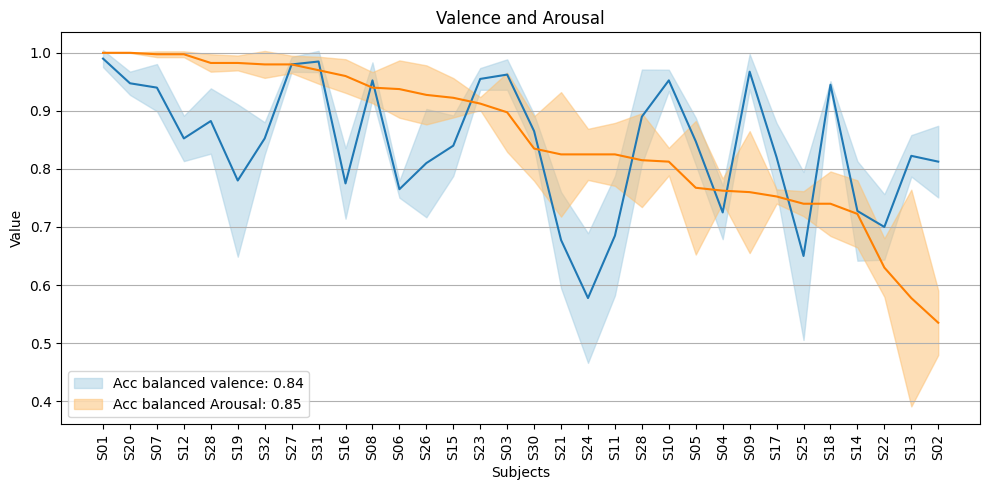

In [ ]:
subjects = np.arange(32)  # Array of subjects
mean_valence = ACCs_valence[indx_arousal, 0]  # Mean values of valence
std_valence = ACCs_valence[indx_arousal, 1]  # Standard deviations of valence
mean_arousal = ACCs_arousal[indx_arousal, 0]  # Mean values of arousal
std_arousal = ACCs_arousal[indx_arousal, 1]  # Standard deviations of arousal

plt.figure(figsize=(10, 5))

# Plot valence
plt.fill_between(subjects, mean_valence - std_valence, mean_valence + std_valence, alpha=0.5, label=labels[1], color=colors[0])
plt.plot(subjects, mean_valence, color=colors[1])

# Plot arousal
plt.fill_between(subjects, mean_arousal - std_arousal, mean_arousal + std_arousal, alpha=0.5, label=labels[0], color=colors[6])
plt.plot(subjects, mean_arousal, color=colors[7])

plt.xticks(subjects, ticks[indx_arousal], rotation = 90)

plt.grid(True, 'both', axis='y', zorder=0)
plt.xlabel('Subjects')
plt.ylabel('Value')
plt.title('Valence and Arousal')
plt.legend()

plt.tight_layout()
plt.show()

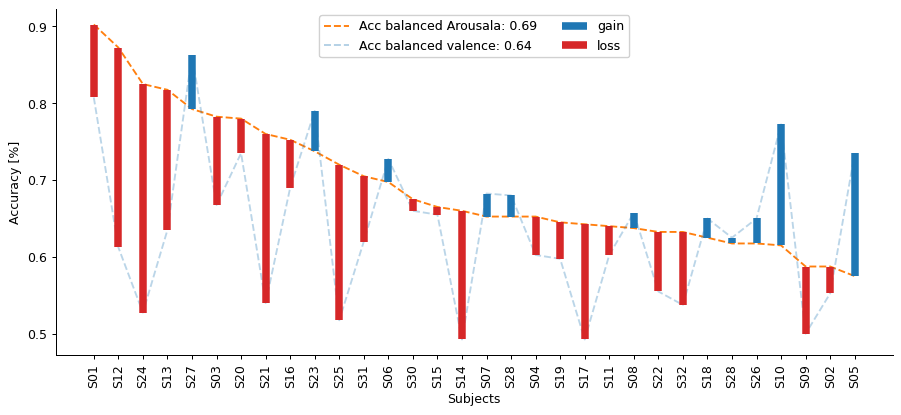

In [ ]:
fig = agco(
    ACCs_arousal, ACCs_valence, ticks, labels, sort='method_1',

    # styles
    reference_c='C1',
    gain_c='C0',
    loss_c='C3',
    barwidth=6,

    # labels
    ylabel='Accuracy [%]',
    xlabel='Subjects',
    gain_labels=['gain', 'loss'],

    # figure options
    size=(12, 5),
    fig=None,
    ax=None,
    dpi=90,
)

In [ ]:
ACCs_arousal.shape

(32, 2)

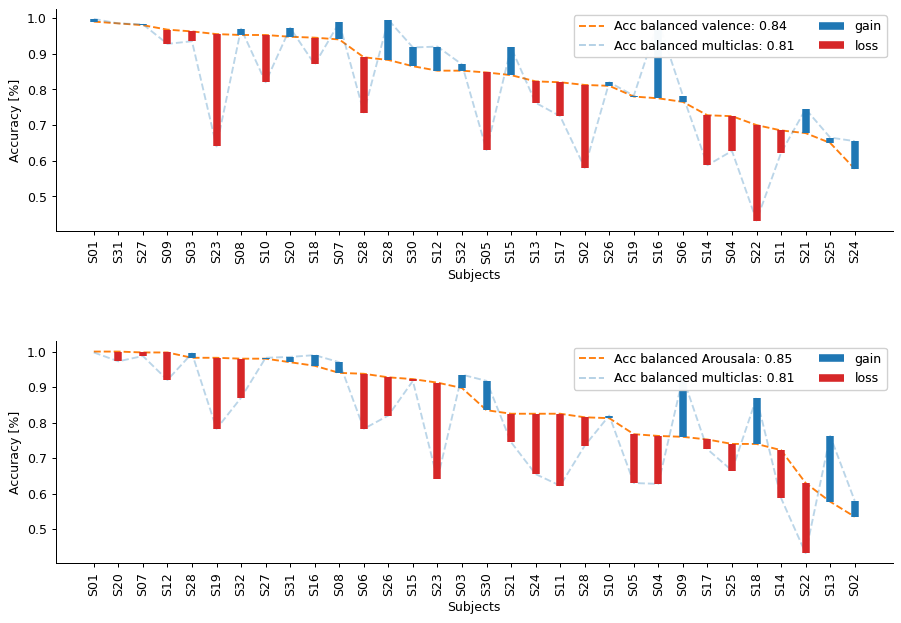

In [ ]:
plt.figure(figsize=(12, 8), dpi=90)

ax1 = plt.subplot(211)
agco(ACCs_valence[:,0], ACCs_multiclass[:,0],  ticks, labels1, sort='method_1', ax=ax1, fig=plt.gcf())
legend = plt.gca().artists[0]
l2 = plt.legend(plt.gca().get_children(), labels1, loc='upper right', ncol=2)
plt.gca().add_artist(l2)
legend.remove()

ax2 = plt.subplot(212)
agco(ACCs_arousal[:,0], ACCs_multiclass[:,0], ticks, labels2, sort='method_1', ax=ax2, fig=plt.gcf())
legend = plt.gca().artists[0]
l2 = plt.legend(plt.gca().get_children(), labels2, loc='upper right', ncol=2)
plt.gca().add_artist(l2)
legend.remove()

plt.subplots_adjust(hspace=0.5)

# Group analisis - semforo

In [ ]:
from sklearn.cluster import KMeans
import matplotlib as mpl

In [ ]:
ACCs_valence = raw_eegnet_valence[:,0]
ACCs_arousal = raw_eegnet_arousal[:,0]
ACCs_multiclass = raw_eegnet_multiclass[:,0]

In [ ]:
kmeans_model = KMeans(n_clusters = 3 )
labels_valence = kmeans_model.fit_predict(raw_eegnet_valence)

kmeans_model = KMeans(n_clusters = 3 )
labels_arousal = kmeans_model.fit_predict(raw_eegnet_arousal)

kmeans_model = KMeans(n_clusters = 3 )
labels_multiclass = kmeans_model.fit_predict(raw_eegnet_multiclass[:,0:4])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
idx_ord_sbj = np.argsort(ACCs_multiclass[:,0])[::-1]

In [ ]:
idx_ord_sbj

array([0, 1])

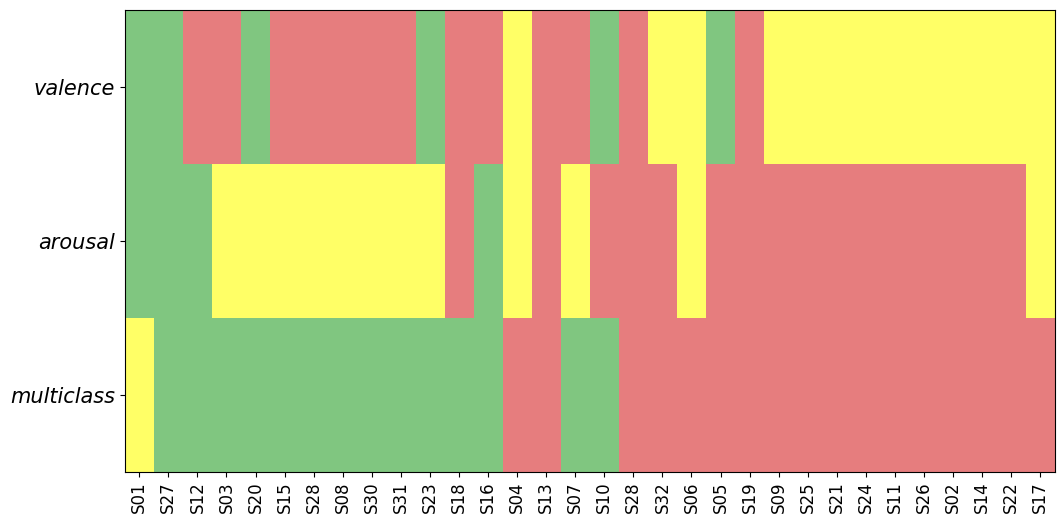

In [ ]:
comparison_grs = np.stack([labels_valence, labels_arousal, labels_multiclass], axis = 0)


colors = ['tab:green', 'tab:red', 'yellow']
cmap = mpl.colors.ListedColormap(colors)

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 6))

_ = axs.imshow(comparison_grs[:, idx_ord_sbj], aspect = 'auto', cmap = cmap, alpha = 0.60)
_ = axs.set_yticks(np.arange(3))
_ = axs.set_yticklabels(['valence', 'arousal', 'multiclass'], fontsize = 15, style = 'italic')
_ = axs.set_xticks(np.arange(ticks.shape[0]))
_ = axs.set_xticklabels(ticks[idx_ord_sbj], fontsize = 12, rotation = 90)
#tikzplotlib.save("semaforo.tex")

# EEG with CKA loss

## functions

In [ ]:
import tensorflow_probability as tfp
import itertools
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

# Define custom loss
#centered kernel alignmet
#http://www.jmlr.org/papers/volume13/cortes12a/cortes12a.pdf
#https://www.frontiersin.org/articles/10.3389/fnins.2017.00550/full
def custom_loss(scaleX=1,scaleY=1):
    #@tf.function()  #decorador para operar sobre python, mas lento y poco efectivo en muchos casos
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def custom_cka_loss(y_true,y_pred): #ytrue labels, ypred  = Xw
        ####gradiente##########################################
        y_true = tf.cast(y_true,dtype=tf.float32)
        y_pred = tf.cast(y_pred,dtype=tf.float32)
        scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale= tf.cast(scaleX,dtype=tf.float32))
        scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=tf.cast(scaleY,dtype=tf.float32))
        k = scalar_kernel.matrix(y_pred, y_pred)
        l = scalar_kernely.matrix(y_true, y_true)
        ######################################################
        N = tf.shape(l)[0]
        N2 = tf.cast(tf.shape(l)[0],dtype=tf.float32)
        h = tf.eye(N) - (1.0/N2)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
        trkl = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(l,h)))
        trkk = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(k,h)))
        trll = tf.linalg.trace(tf.matmul(tf.matmul(l,h),tf.matmul(l,h)))
        #####funcion de costo############################################3
        f     = -trkl/tf.sqrt(trkk*trll)# negative cka cost function (minimizing) f \in [-1,0]
        return f
    # Return a function
    return custom_cka_loss

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans = 64, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:

        1. Depthwise Convolutions to learn spatial filters within a
        temporal convolution. The use of the depth_multiplier option maps
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn
        spatial filters within each filter in a filter-bank. This also limits
        the number of free parameters to fit when compared to a fully-connected
        convolution.

        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions.


    While the original paper used Dropout, we found that SpatialDropout2D
    sometimes produced slightly better results for classification of ERP
    signals. However, SpatialDropout2D significantly reduced performance
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.

    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the
    kernel lengths for double the sampling rate, etc). Note that we haven't
    tested the model performance with this rule so this may not work well.

    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D.
    Inputs:

      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D.
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    regularizer_o = tf.keras.regularizers.OrthogonalRegularizer(factor=1e-3)


    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   name='Conv2D_1',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   name='Depth_wise_Conv2D_1',
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   name='Separable_Conv2D_1',
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'output', activation = 'linear',
                         kernel_constraint = max_norm(norm_rate), kernel_regularizer=regularizer_o)(flatten)
    #sigmoid      = Activation('linear', name = 'out_activation', kernel_regularizer=regularizer_o)(dense)

    return Model(inputs=input1, outputs=dense)

## Model

In [ ]:
path_DEAP = '/content/drive/Shareddrives/GCPDS-Databases/DEAP/'
save_path = '/content/drive/MyDrive/music_VAEs/DEAP_dataset/'
save_models_path = '/content/drive/MyDrive/music_VAEs/DEAP_dataset/EEG/cross_val_results/'


N_subs = 32
N_trials = 40
N_chann = 32
fs = 128 #Hz
len_data = 7680# len without the initial seconds 8064
len_wind = 6 # 6 segs windows
N_windws =len_data/ (len_wind*fs) # 10 windows from 6 seconds


labels = 1 #(valence, arousal, dominance, liking)
f_bank = np.asarray([4., 40.])
lr = 1e-2
epochs = 500
verbose = 1

seed = 123
folds = 5

##save data

data_set = 'DEAP'
model_name = 'multiclass'
Experiment = 'cross_val'

Fold 0:
params: scale X 0.1, Kernel length 128
Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: -0.1005 - val_loss: -0.2014
Epoch 2/500
1/1 [==============================] - 0s 181ms/step - loss: -0.0560 - val_loss: -0.2030
Epoch 3/500
1/1 [==============================] - 0s 164ms/step - loss: -0.0853 - val_loss: -0.2029
Epoch 4/500
1/1 [==============================] - 0s 137ms/step - loss: -0.0897 - val_loss: -0.2030
Epoch 5/500
1/1 [==============================] - 0s 132ms/step - loss: -0.0948 - val_loss: -0.2030
Epoch 6/500
1/1 [==============================] - 0s 126ms/step - loss: -0.1010 - val_loss: -0.2031
Epoch 7/500
1/1 [==============================] - 0s 131ms/step - loss: -0.0993 - val_loss: -0.2027
Epoch 8/500
1/1 [==============================] - 0s 120ms/step - loss: -0.0985 - val_loss: -0.2032
Epoch 9/500
1/1 [==============================] - 0s 121ms/step - loss: -0.0995 - val_loss: -0.2030
Epoch 10/500
1/1 [=============================

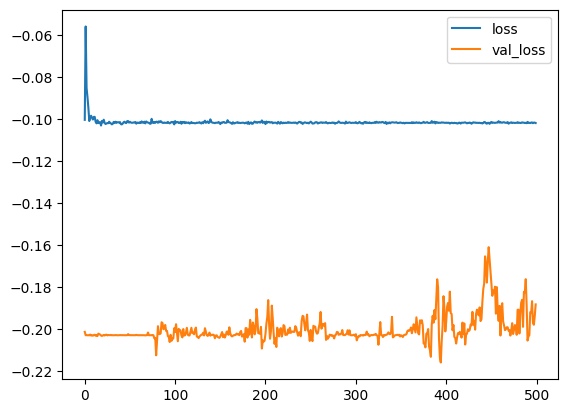

13/13 [==============================] - 0s 4ms/step


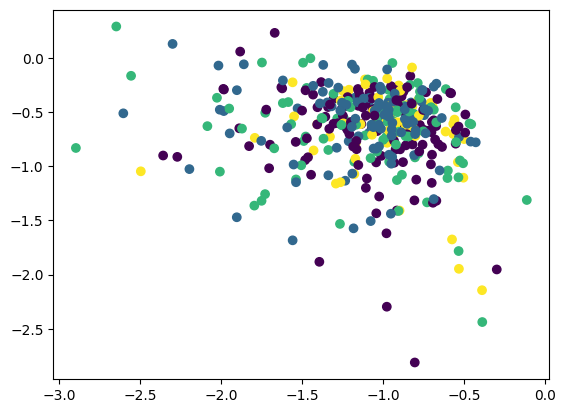

best params: 
{'best_loss': -0.27152442932128906, 'kernLength': 128, 'scaleX': 0.1}
Fold 1:
params: scale X 0.1, Kernel length 128
Epoch 1/500
1/1 [==============================] - 7s 7s/step - loss: -0.1030 - val_loss: -0.1996
Epoch 2/500
1/1 [==============================] - 0s 163ms/step - loss: -0.0609 - val_loss: -0.2047
Epoch 3/500
1/1 [==============================] - 0s 151ms/step - loss: -0.0786 - val_loss: -0.2046
Epoch 4/500
1/1 [==============================] - 0s 123ms/step - loss: -0.0895 - val_loss: -0.2047
Epoch 5/500
1/1 [==============================] - 0s 109ms/step - loss: -0.0927 - val_loss: -0.2046
Epoch 6/500
1/1 [==============================] - 0s 107ms/step - loss: -0.1003 - val_loss: -0.2045
Epoch 7/500
1/1 [==============================] - 0s 103ms/step - loss: -0.1005 - val_loss: -0.2046
Epoch 8/500
1/1 [==============================] - 0s 109ms/step - loss: -0.1015 - val_loss: -0.2045
Epoch 9/500
1/1 [==============================] - 0s 113ms/step

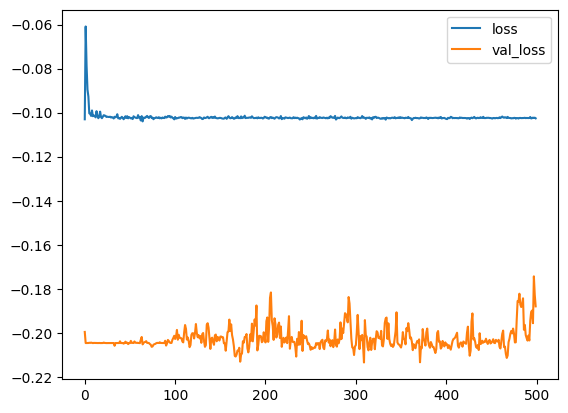

13/13 [==============================] - 0s 5ms/step


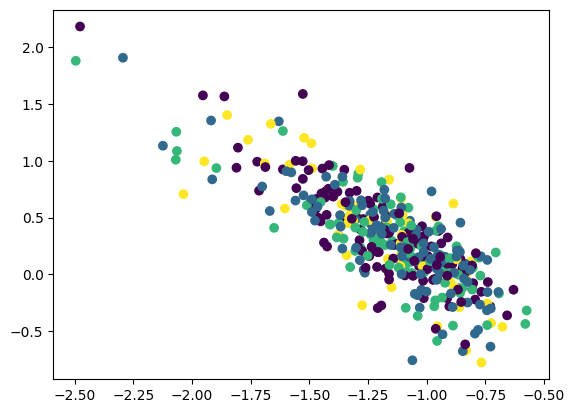

best params: 
{'best_loss': -0.2685109078884125, 'kernLength': 128, 'scaleX': 0.1}
Fold 2:
params: scale X 0.1, Kernel length 128
Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: -0.1011 - val_loss: -0.2078
Epoch 2/500
1/1 [==============================] - 0s 169ms/step - loss: -0.0517 - val_loss: -0.2086
Epoch 3/500
1/1 [==============================] - 0s 144ms/step - loss: -0.0817 - val_loss: -0.2086
Epoch 4/500
1/1 [==============================] - 0s 121ms/step - loss: -0.0859 - val_loss: -0.2086
Epoch 5/500
1/1 [==============================] - 0s 120ms/step - loss: -0.0945 - val_loss: -0.2085
Epoch 6/500
1/1 [==============================] - 0s 108ms/step - loss: -0.0931 - val_loss: -0.2086
Epoch 7/500
1/1 [==============================] - 0s 105ms/step - loss: -0.1006 - val_loss: -0.2084
Epoch 8/500
1/1 [==============================] - 0s 107ms/step - loss: -0.0958 - val_loss: -0.2083
Epoch 9/500
1/1 [==============================] - 0s 107ms/step 

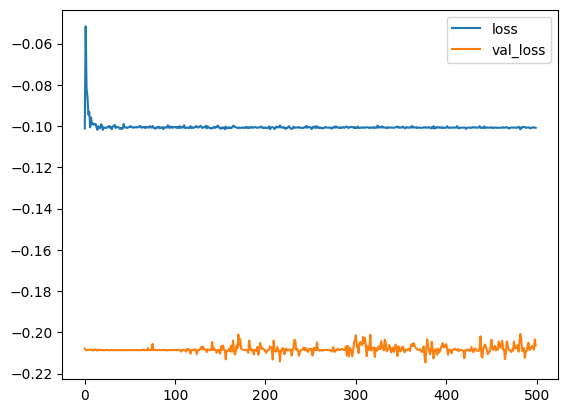

13/13 [==============================] - 0s 6ms/step


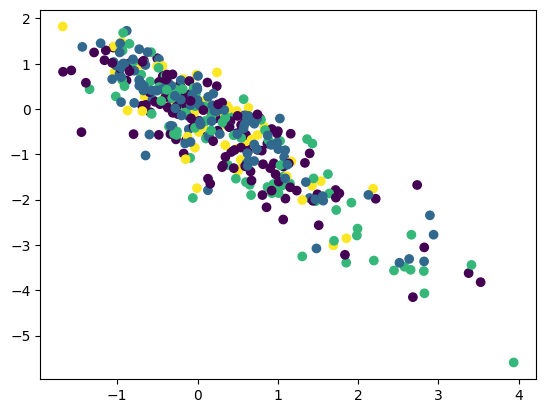

best params: 
{'best_loss': -0.279779314994812, 'kernLength': 128, 'scaleX': 0.1}
Fold 3:
params: scale X 0.1, Kernel length 128
Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: -0.0999 - val_loss: -0.1882
Epoch 2/500
1/1 [==============================] - 0s 169ms/step - loss: -0.0495 - val_loss: -0.2082
Epoch 3/500
1/1 [==============================] - 0s 136ms/step - loss: -0.0847 - val_loss: -0.2082
Epoch 4/500
1/1 [==============================] - 0s 123ms/step - loss: -0.0907 - val_loss: -0.2081
Epoch 5/500
1/1 [==============================] - 0s 108ms/step - loss: -0.0920 - val_loss: -0.2081
Epoch 6/500
1/1 [==============================] - 0s 107ms/step - loss: -0.1015 - val_loss: -0.2082
Epoch 7/500
1/1 [==============================] - 0s 106ms/step - loss: -0.0994 - val_loss: -0.2083
Epoch 8/500
1/1 [==============================] - 0s 107ms/step - loss: -0.0970 - val_loss: -0.2081
Epoch 9/500
1/1 [==============================] - 0s 114ms/step -

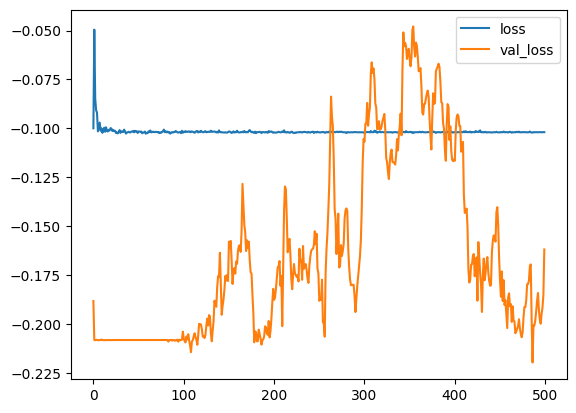

13/13 [==============================] - 0s 4ms/step


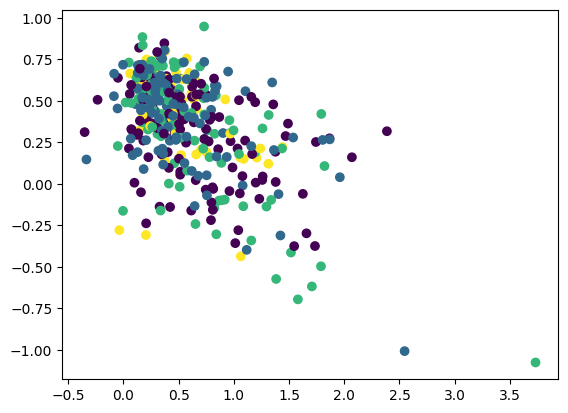

best params: 
{'best_loss': -0.26944831013679504, 'kernLength': 128, 'scaleX': 0.1}
Fold 4:
params: scale X 0.1, Kernel length 128
Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: -0.1013 - val_loss: -0.1958
Epoch 2/500
1/1 [==============================] - 0s 175ms/step - loss: -0.0571 - val_loss: -0.2076
Epoch 3/500
1/1 [==============================] - 0s 158ms/step - loss: -0.0887 - val_loss: -0.2076
Epoch 4/500
1/1 [==============================] - 0s 129ms/step - loss: -0.0892 - val_loss: -0.2077
Epoch 5/500
1/1 [==============================] - 0s 122ms/step - loss: -0.0965 - val_loss: -0.2075
Epoch 6/500
1/1 [==============================] - 0s 127ms/step - loss: -0.0987 - val_loss: -0.2076
Epoch 7/500
1/1 [==============================] - 0s 112ms/step - loss: -0.0986 - val_loss: -0.2072
Epoch 8/500
1/1 [==============================] - 0s 118ms/step - loss: -0.1014 - val_loss: -0.2070
Epoch 9/500
1/1 [==============================] - 0s 115ms/step

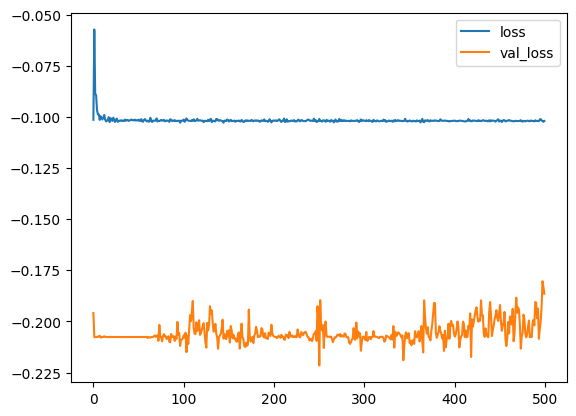

13/13 [==============================] - 0s 4ms/step


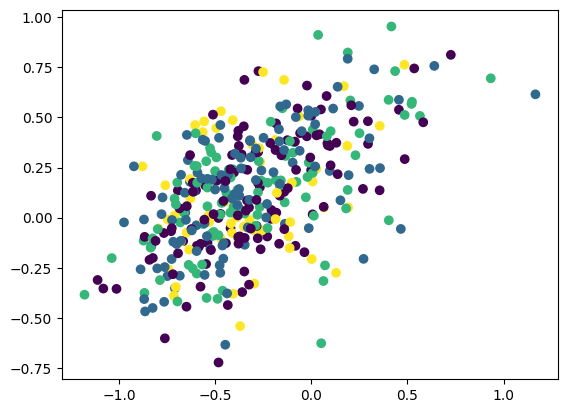

best params: 
{'best_loss': -0.2838117778301239, 'kernLength': 128, 'scaleX': 0.1}


In [ ]:

learning_rate = 0.1
n_splits = 5

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=0)
sss.get_n_splits(X_train, y_train)
recontrution_loss = np.zeros((n_splits, 2)) #to save Dice loss and cka loss


Acc_losses = np.zeros((n_splits,))

n_trains = len(list(itertools.product(validation, Dice_weigths)))

all_acc = np.zeros((n_splits,n_trains,2)) #to save acc valence and arousal

batch_size, Chans, Samples, _ = X_train.shape
model_args = {'nb_classes':np.unique(y_train).shape[0],'Chans':Chans,'Samples':Samples,'dropoutRate':0.6,
            'kernLength':128,'F1':4,'D':4,'F2':32,'norm_rate':0.25,'dropoutType':'Dropout'}

scaleX_s = [0.1, 0.5, 1,2]
kernLength_s = [128]

for i, (train_index, test_index) in enumerate(sss.split(X_train, y_train)):
  print(f"Fold {i}:")

  best_cka = None
  best_hyperparameters = {}
  trains_count = 0

  for scal, kernLength in itertools.product(scaleX_s, kernLength_s):
    print(f"params: scale X {scal}, Kernel length {kernLength}" )

    #call models
    clf = EEGNet(nb_classes = model_args['nb_classes'],
                    Chans = model_args['Chans'],
                    Samples = model_args['Samples'],
                    dropoutRate = model_args['dropoutRate'],
                    kernLength = kernLength,
                    F1 = model_args['F1'], D = model_args['D'], F2 = model_args['F2'],
                    )

    #call losses and callback

    reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=30, verbose=verbose, mode='min', min_delta=0.01, min_lr=0)
    terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()
    callbacks = [terminate_on_nan]
    loss = custom_loss(scaleX=scal,scaleY=1)
    opt = tf.keras.optimizers.Adam(learning_rate= learning_rate)


    #compile

    clf.compile(loss= loss, optimizer=opt)
    history = clf.fit( X_train[train_index],y_matriz[train_index], epochs = epochs,
                      batch_size=500, callbacks=callbacks, validation_split=0.2, verbose=1)


    evaluation = clf.evaluate(X_train[test_index],y_matriz[test_index] )

    #### Accuracy Metrics

    y_predict = clf.predict(X_train[test_index])
    #
    acc_valence= accuracy_score((y_predict[:,0]<0)*1, y_matriz[test_index,0])
    acc_arousal = accuracy_score((y_predict[:,1]<0)*1, y_matriz[test_index,1])
    all_acc[i,trains_count ] = (acc_valence, acc_arousal)
    print(f'aciertos de valence y arousal: {acc_valence}, {acc_arousal}, evaluation loss: {evaluation}' )


    ###plot stuffs
    hpd = pd.DataFrame(history.history)
    hpd[['loss','val_loss']].plot()
    plt.show()

    Xcka = clf.predict(X_train)
    Xcka.shape
    plt.scatter(Xcka[:,0],Xcka[:,1],c = y_train_multiclass)
    plt.show()

    if best_cka is None or evaluation[1] < best_cka:

      best_hyperparameters = {
          'best_loss': evaluation,
          'kernLength': kernLength,
          'scaleX': scal
      }

      recontrution_loss[i,] = evaluation
      trains_count = trains_count+1

  print(f"best params: ")
  print(best_hyperparameters)

  #del clf

# path_save_acc = '/content/drive/MyDrive/music_VAEs/DEAP_dataset/paper_version_codes'

# np.save(path_save_acc, all_acc)

In [ ]:
print(all_acc )

[[[0.5        0.525     ]]

 [[0.44166667 0.525     ]]

 [[0.475      0.425     ]]

 [[0.5        0.48333333]]

 [[0.48333333 0.475     ]]]


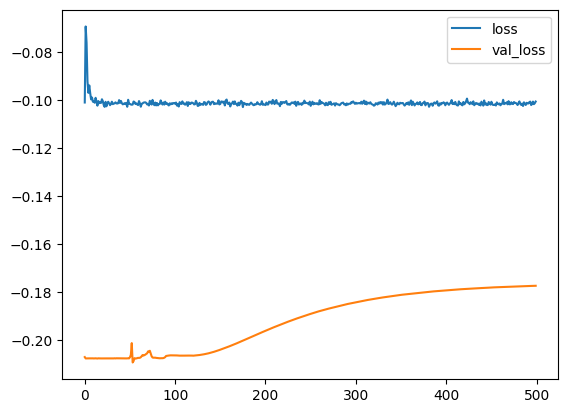

13/13 [==============================] - 0s 7ms/step


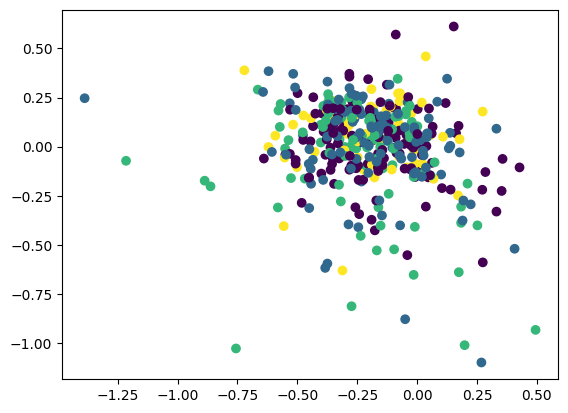

In [ ]:
hpd = pd.DataFrame(history.history)
hpd[['loss','val_loss']].plot()
plt.show()

Xcka = clf.predict(X_train)
Xcka.shape
plt.scatter(Xcka[:,0],Xcka[:,1],c = y_train_multiclass)


#plt.scatter(Xcka[:,0],Xcka[:,1],c = label_multiclass)
plt.show()
